# Connected Components Analysis

In [1]:
//load ImageJ
%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: scijava.public


net.imagej.ImageJ@16aac200

This `Op` wraps the Connected Components Analysis (CCA), an algorithm that links all connected pieces of a binary `RandomAccessibleInterval`, given as an `ImgLabeling`. The `Op` is called as follows:

In [2]:
ij.op().help('cca')

Available operations:
	(ImgLabeling out?) =
	net.imagej.ops.labeling.cca.DefaultCCA(
		ImgLabeling out?,
		RandomAccessibleInterval in,
		StructuringElement se,
		Iterator labelGenerator?)

CCA can be extremely useful when quanitifying small regions within an image:

[INFO] Verifying GIF format
[INFO] Reading dimensions
[INFO] Reading data blocks


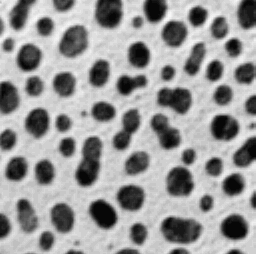

In [3]:
import net.imglib2.FinalInterval

image = ij.scifio().datasetIO().open("http://imagej.net/images/blobs.gif")

w = image.dimension(0); h = image.dimension(1)
slice = FinalInterval.createMinSize(0, 0, 0, w, h, 1)
input = ij.op().run("crop", image, slice, true)

ij.notebook().display(input)

CCA runs over binary images so that it can easily discern which data locations should be allocated into labels, so first we have to binarize the image. Any data location with a bright value (i.e. `1`) will be labeled. However because we want to label the blobs (and not the background) we have to invert it first:

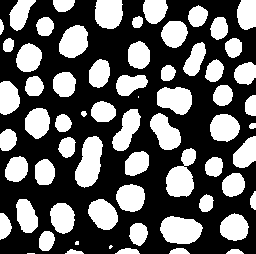

In [4]:
import net.imagej.ops.Ops
import net.imagej.ops.OpService
import net.imagej.ops.special.computer.Computers

//make the blobs bright by using a invert op.
inverted = ij.op().create().img(input)
ij.op().image().invert(inverted, input)

//binarize the image using the inverted input
binary = ij.op().threshold().mean(inverted)

ij.notebook().display(binary)

Now that we have a binarized, inverted input we can use CCA to find all of the blobs. Note that CCA also takes a `StructuringElement`, an `enum` determining whether to consider diagonal pixels (`EIGHT_CONNECTED`) or only the pixels above, below, to the left, and to the right (`FOUR_CONNCTED`) as neighbors:

In [5]:
import net.imglib2.algorithm.labeling.ConnectedComponents.StructuringElement

blobsLabeling = ij.op().labeling().cca(binary,StructuringElement.FOUR_CONNECTED)

net.imglib2.roi.labeling.ImgLabeling@5e562781

Our `ImgLabeling` output contains an `IndexImg`, an `Img` that assigns a grayscale value to each pixel in a region, unique in value compared to all the other regions:

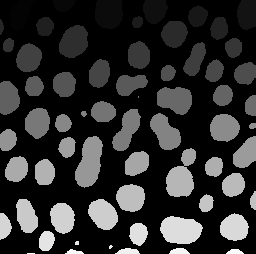

In [6]:
indexImg = blobsLabeling.getIndexImg()

ij.notebook().display(indexImg)

The `ImgLabling` itself is comprised of `LabelRegion`s, and we can get a list of all of the `LabelRegion` objects by using `LabelRegions`. Then we can find the center of mass of each labeling by interrogating each `LabelRegion`:

In [7]:
import net.imglib2.roi.labeling.LabelRegions
import net.imglib2.RealLocalizable

regions = new LabelRegions(blobsLabeling)
centers = new ArrayList<RealLocalizable>()
for(region in regions)
    centers.add(region.getCenterOfMass())

null

Now we can overlay the centers of mass onto the original image:

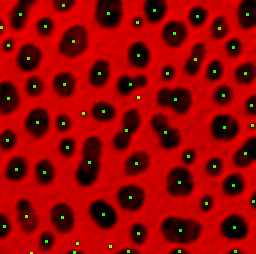

In [8]:
import net.imglib2.view.Views

//create an Img upon which to paint all of the centers of mass
centerImg = ij.op().create().img(input)
centerRA = centerImg.randomAccess()

//get the maximum possible value allowed to store in the img
maxValue = centerImg.firstElement().getMaxValue() as int
    
//paint the centers onto the img as 3x3 squares
for(center in centers){
    for(dx = -1; dx <= 1 ; dx++){
        for(dy = -1; dy <= 1 ; dy++){
            //current pixel to paint is center location + offset
            xPos = Math.round(center.getDoublePosition(0)) + dx
            yPos = Math.round(center.getDoublePosition(1)) + dy
            //if pixel + offset is outside the image bounds, don't attempt to paint
            if(xPos >= centerImg.dimension(0) || yPos >= centerImg.dimension(1)) continue
            centerRA.setPosition(xPos, 0)
            centerRA.setPosition(yPos, 1)
            //paint
            centerRA.get().set(maxValue)
        }
    }
}

//stack the centers on the input image
stack = Views.stack(input, centerImg)

//TODO place in table next to original
ij.notebook().display(stack)
